In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses

import math
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt


In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Colab Notebooks/ML /dataA.csv"

Mounted at /content/drive


In [ ]:
# read csv file from data.csv file
nepse_df = pd.read_csv(file_path, header = 0)

In [ ]:
# Check the data in the top of the dataframe
nepse_df.head()
nepse_df.shape

(5399, 8)

In [ ]:
# Check of null or missing data
nepse_df.isnull().sum()

Symbol            0
Date              0
Open              0
High              0
Low               0
Close             0
percent_change    0
Volume            0
dtype: int64

In [ ]:
# Filter data based on choice
class CustomError(Exception):
  pass

scrip_list = list(nepse_df['Symbol'].unique())
print("Available Scrip are", scrip_list)
SCRIP = input("Enter the Scrip you want to analyze: ")

if SCRIP in scrip_list:
  nepse_df = nepse_df[nepse_df['Symbol'] == SCRIP]
else:
  print("Scrip is not valid")
  raise CustomError("Wrong Input")

Available Scrip are ['LBBL', 'NABIL', 'NBL', 'NHPC', 'SICL']
Enter the Scrip you want to analyze: LBBL


In [ ]:
# Perform 80 - 20 split for training and test data
values = nepse_df['Close'].values
training_data_len = math.ceil(len(values)* 0.8)

In [ ]:
scaler = StandardScaler() # Scaling
scaled_data = scaler.fit_transform(values.reshape(-1, 1))

In [ ]:
train_data = scaled_data[0: training_data_len, :]

window_size = 5
x_train = []
y_train = []

# Create a window for the prediction dependency
for i in range(window_size, len(train_data)):
    x_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
test_data = scaled_data[training_data_len-window_size: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(window_size, len(test_data)):
  x_test.append(test_data[i-window_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Build a Model



### 1. RNN Model

In [ ]:
# Define the RNN Model
model = keras.Sequential([
                          layers.SimpleRNN(units = 50, return_sequences=True, input_shape = (x_train.shape[1], 1)),
                          layers.Dropout(0.2),
                          layers.SimpleRNN(units = 75, return_sequences = False),
                          layers.Dropout(0.2),
                          layers.Dense(units = 20),
                          layers.Dense(units = 1)
])

model.compile(optimizer = 'rmsprop', loss = tf.losses.mean_squared_error, metrics = ['mean_absolute_error'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 5, 50)             2600      
                                                                 
 dropout (Dropout)           (None, 5, 50)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 75)                9450      
                                                                 
 dropout_1 (Dropout)         (None, 75)                0         
                                                                 
 dense (Dense)               (None, 20)                1520      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 13,591
Trainable params: 13,591
Non-traina

In [ ]:
epochs = 100
history = model.fit(x_train, y_train, epochs = epochs, validation_split=0.1)

Epoch 1/100
26/26 [==============================] - 2s 22ms/step - loss: 0.2984 - mean_absolute_error: 0.3626 - val_loss: 0.0044 - val_mean_absolute_error: 0.0631
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 0.1026 - mean_absolute_error: 0.2385 - val_loss: 0.0999 - val_mean_absolute_error: 0.3154
Epoch 3/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0784 - mean_absolute_error: 0.2006 - val_loss: 0.0087 - val_mean_absolute_error: 0.0904
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0635 - mean_absolute_error: 0.1789 - val_loss: 0.0430 - val_mean_absolute_error: 0.2058
Epoch 5/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0495 - mean_absolute_error: 0.1530 - val_loss: 0.0018 - val_mean_absolute_error: 0.0384
Epoch 6/100
26/26 [==============================] - 0s 4ms/step - loss: 0.0472 - mean_absolute_error: 0.1532 - val_loss: 0.0090 - val_mean_absolute_error: 0.0930
Epoch 7/100
26/26 [==

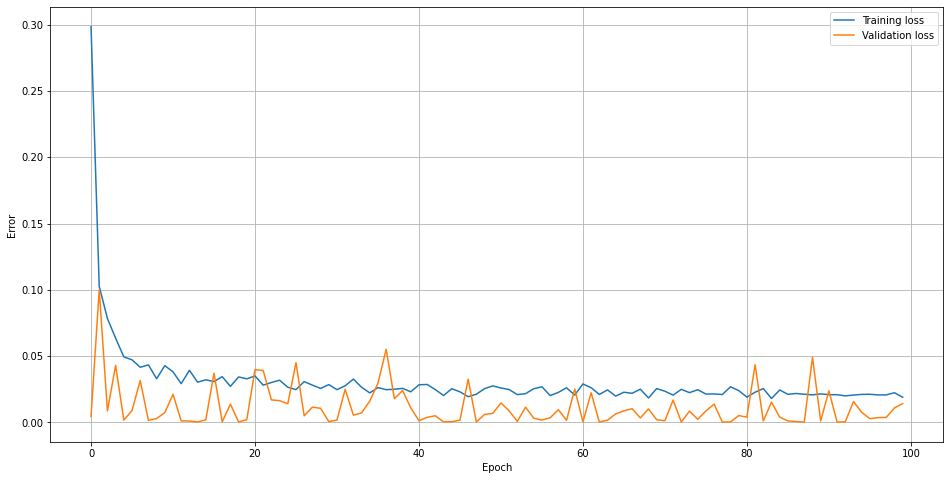

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(16,8))
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rnn_rmse = np.sqrt(np.mean(predictions - y_test)**2)
rnn_rmse

8/8 [==============================] - 0s 2ms/step


13.32846555456651

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


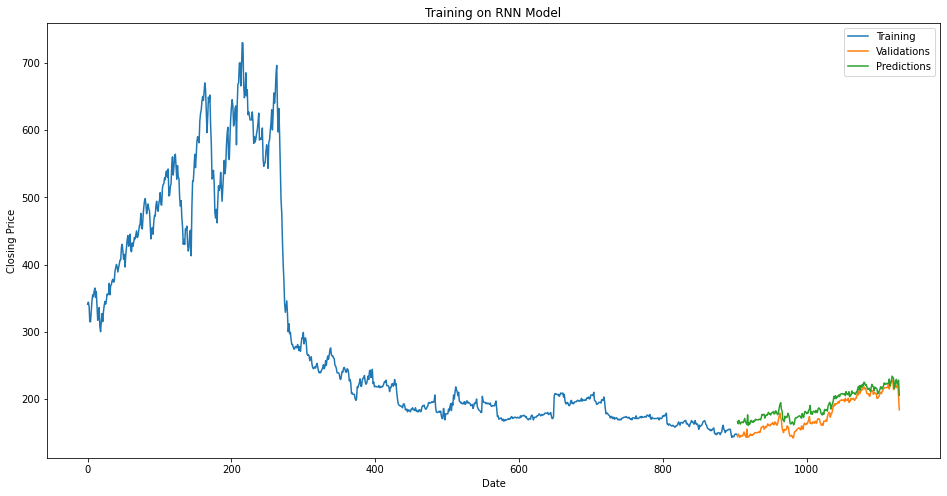

In [ ]:
data = nepse_df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Training on RNN Model')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Training', 'Validations', 'Predictions'], loc='upper right')
plt.show()

### 2. LSTM Model

In [ ]:
# Define the RNN Model
model = keras.Sequential([
                          layers.LSTM(units = 50, return_sequences=True, input_shape = (x_train.shape[1], 1)),
                          layers.Dropout(0.2),
                          layers.LSTM(units = 75, return_sequences = False),
                          layers.Dropout(0.2),
                          layers.Dense(units = 20),
                          layers.Dense(units = 1)
])

model.compile(optimizer = 'rmsprop', loss = tf.losses.mean_squared_error, metrics = ['mean_absolute_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                                 
 dropout_2 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 75)                37800     
                                                                 
 dropout_3 (Dropout)         (None, 75)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                1520      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 49,741
Trainable params: 49,741
Non-trai

In [ ]:
epochs = 50
history = model.fit(x_train, y_train, epochs = epochs, validation_split=0.2)

Epoch 1/50
23/23 [==============================] - 4s 37ms/step - loss: 0.2193 - mean_absolute_error: 0.2805 - val_loss: 0.0091 - val_mean_absolute_error: 0.0912
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0476 - mean_absolute_error: 0.1343 - val_loss: 0.0112 - val_mean_absolute_error: 0.1019
Epoch 3/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0456 - mean_absolute_error: 0.1305 - val_loss: 0.0038 - val_mean_absolute_error: 0.0555
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0445 - mean_absolute_error: 0.1302 - val_loss: 9.4334e-04 - val_mean_absolute_error: 0.0226
Epoch 5/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0349 - mean_absolute_error: 0.1179 - val_loss: 6.4441e-04 - val_mean_absolute_error: 0.0185
Epoch 6/50
23/23 [==============================] - 0s 8ms/step - loss: 0.0404 - mean_absolute_error: 0.1246 - val_loss: 7.0584e-04 - val_mean_absolute_error: 0.0190
Epoch 7/50
23/2

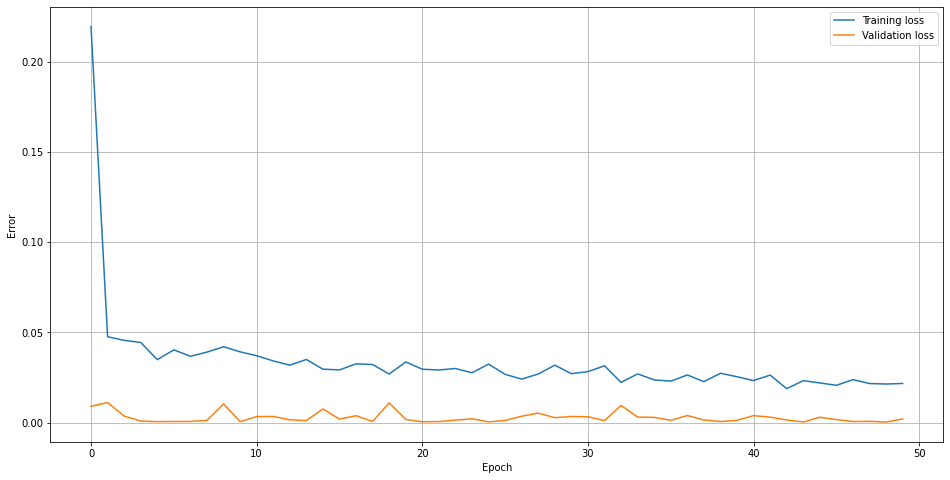

In [ ]:
plot_loss(history)

In [ ]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
lstm_rmse = np.sqrt(np.mean(predictions - y_test)**2)
lstm_rmse

8/8 [==============================] - 1s 3ms/step


4.456354191872926

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


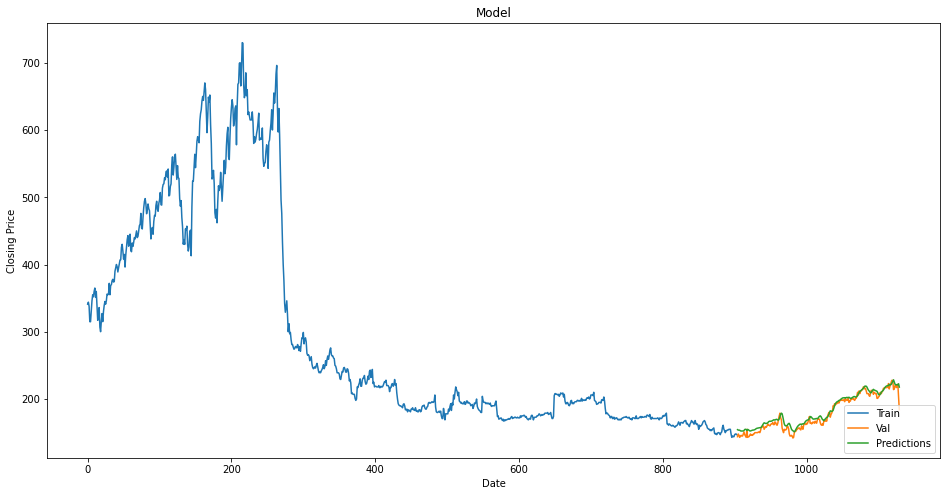

In [ ]:
data = nepse_df.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
if rnn_rmse > lstm_rmse:
  print("RNN works better than LSTM for", SCRIP)
elif rnn_rmse < lstm_rmse:
  print("LSTM works better than RMSE for", SCRIP)
else:
  print("The performance of RNN and LSTM are same.")

RNN works better than LSTM for LBBL
